### Importing libraries and connecting to SQL database

In [1]:
import pandas as pd
import pyodbc
import numpy as np
import pickle
import matplotlib.pyplot as plt 

server = 'database2108.database.windows.net' 
database = 'group6' 
username = 'group6user' 
password = 'everythingIsAwesome!'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
query = "SELECT * FROM dbo.videogamesSales_full;"
vg = pd.read_sql(query, cnxn)
vg.shape

(2416, 15)

### Prepping Dataset for ML Model

In [2]:
#dropping unnecessary columns, and nulls
vg = vg.drop(columns=['JP_Sales','NA_Sales','Other_Sales','PAL_Sales','timestamp','Rank'])
vg.dropna(inplace=True)

In [3]:
#there are too many unique Developers and Publishers, especially non-prominent ones, so I'm grouping the not so prominent ones together to reduce load and overfitting model
#starting with developers
oneDev = vg.groupby('Developer').filter(lambda x:len(x) == 1)
twoDev = vg.groupby('Developer').filter(lambda x:len(x) == 2)
threeDev = vg.groupby('Developer').filter(lambda x:len(x) == 3)
fourDev = vg.groupby('Developer').filter(lambda x:len(x) == 4)
popDev = vg.groupby('Developer').filter(lambda x:len(x) >= 5)

#grouping them back as one dataframe
oneDev['Developer'] = 'OneHits'
twoDev['Developer'] = 'TwoHits'
threeDev['Developer'] = 'ThreeHits'
fourDev['Developer'] = 'FourHits'
concatDevs = pd.concat([oneDev,twoDev,threeDev,fourDev,popDev])

#then using that dataframe, filtering out non-prominent publishers
onePub = concatDevs.groupby('Publisher').filter(lambda x:len(x) == 1)
twoPub = concatDevs.groupby('Publisher').filter(lambda x:len(x) == 2)
threePub = concatDevs.groupby('Publisher').filter(lambda x:len(x) == 3)
fourPub = concatDevs.groupby('Publisher').filter(lambda x:len(x) == 4)
popPub = concatDevs.groupby('Publisher').filter(lambda x:len(x) >= 5)

#re-grouping as one final, condensed dataframe
onePub['Publisher'] = 'OnePubs'
twoPub['Publisher'] = 'TwoPubs'
threePub['Publisher'] = 'ThreePubs'
fourPub['Publisher'] = 'FourPubs'
concatVg = pd.concat([onePub,twoPub,threePub,fourPub,popPub])

In [4]:
#adding name-lenght column of game title, and doing a log-normal transformation of global sales (so I can make the most of limited dataset without having to remove outliers)
concatVg['NameLength'] = concatVg['Name'].str.len()
concatVg['log_Global_Sales'] = (np.log(concatVg['Global_Sales']))

In [5]:
#making a new datafram with all the columns I want to use for my ML model
newvg = concatVg[['NameLength','Critic_Score','ESRB_Rating','Genre','Platform','Publisher','Developer','Year','log_Global_Sales']]

In [6]:
#making dummy variables of categorical data
vgc2 = pd.get_dummies(newvg, columns=['ESRB_Rating','Genre','Platform','Developer','Publisher'], drop_first=True)

In [7]:
#separating out my target, global sales
x = vgc2.drop('log_Global_Sales', axis=1)
y = vgc2['log_Global_Sales']

In [8]:
#splitting dataframe into training and testing sets, using 70/30 split, with random state set at 1 for consistency between runs
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1)
actual_y = y_test

### Implementing ML Model: Gradient Boost Regressor

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
gboostm1 = GradientBoostingRegressor(learning_rate=0.001, max_depth=5, max_features='sqrt', n_estimators=15000, random_state=1).fit(x_train,y_train)
gboosttrainscore = gboostm1.score(x_train,y_train)
gboosttestscore = gboostm1.score(x_test,y_test)
print('Gradient Boost Results:')
print('Gradient Boost Training:', gboosttrainscore, 'Gradient Boost Testing:', gboosttestscore)

Gradient Boost Results:
Gradient Boost Training: 0.7946774284996443 Gradient Boost Testing: 0.6040190179298747


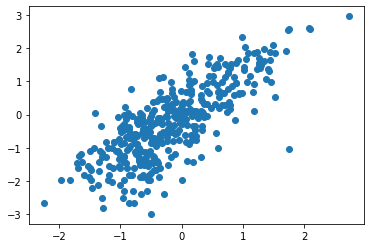

In [11]:
#checking fit
predgboost = gboostm1.predict(x_test)
plt.scatter(predgboost,actual_y)
plt.show()

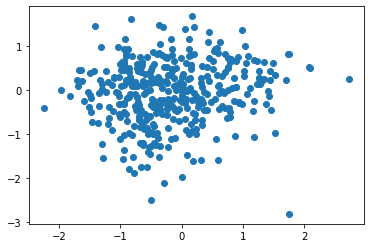

In [12]:
#checking residuals
residual_gboost = y_test - predgboost
plt.scatter(predgboost, residual_gboost)
plt.show()

### Exporting ML Model and feature-data

In [37]:
#saving ML model for power BI visualizations
filename = 'gradientboostmodel_grouped'
pickle.dump(gboostm1, open(filename,'wb'))

#saving feature importances to .csv for reference in report
imp1 = gboostm1.feature_importances_
imp2 = gboostm1.feature_names_in_
dfimp = pd.DataFrame(imp1,imp2)
dfimp
dfimp.to_csv('checkout_grouped.csv')